In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Định nghĩa đường dẫn dataset
processed_data_dir = "C:/Users/VuongPham/Documents/asl_alphabet/processed_data"
test_dir = "C:/Users/VuongPham/Documents/asl_alphabet/test_data"

# Nhãn ký hiệu
labels = ["K", "L", "M", "N", "O"]
img_size = (224, 224)
batch_size = 64

In [3]:
# Tạo Data Generator với cải tiến
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    processed_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    processed_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 18336 images belonging to 5 classes.
Found 4582 images belonging to 5 classes.
Found 2544 images belonging to 5 classes.


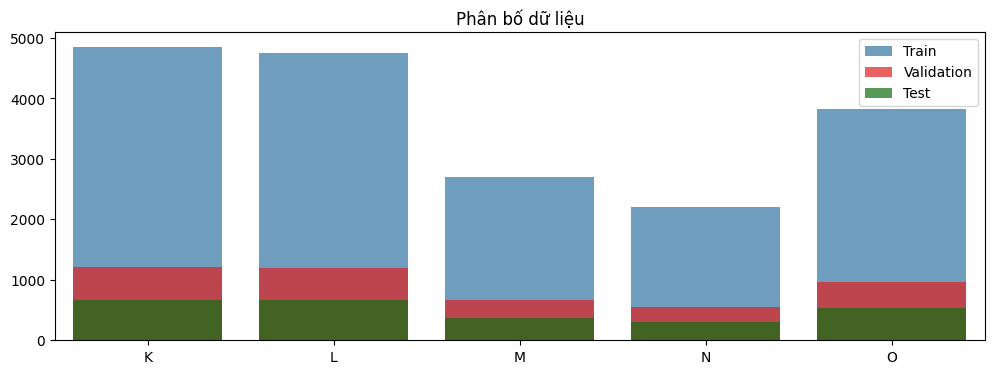

In [4]:
# Phân tích phân bố dữ liệu
def plot_data_distribution():
    train_counts = np.unique(train_generator.classes, return_counts=True)
    val_counts = np.unique(val_generator.classes, return_counts=True)
    test_counts = np.unique(test_generator.classes, return_counts=True)

    plt.figure(figsize=(12, 4))
    sns.barplot(x=labels, y=train_counts[1], label="Train", alpha=0.7)
    sns.barplot(x=labels, y=val_counts[1], label="Validation", alpha=0.7, color="red")
    sns.barplot(x=labels, y=test_counts[1], label="Test", alpha=0.7, color="green")
    plt.legend()
    plt.title("Phân bố dữ liệu")
    plt.show()

plot_data_distribution()

In [5]:
# Load mô hình ResNet50
base_model = ResNet50(weights='imagenet', include_top=False)

# Đóng băng 100 lớp đầu tiên của ResNet50
for layer in base_model.layers[:100]:
    layer.trainable = False

# Xây dựng mô hình với cải tiến
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = GaussianNoise(0.1)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Tạo Learning Rate Scheduler
cosine_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.0005,
    decay_steps=20 * len(train_generator),
    alpha=0.0001
)

optimizer = Adam(learning_rate=cosine_scheduler)

# Biên dịch mô hình
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Hiển thị kiến trúc mô hình
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 24,146,821 (92.11 MB)

 Trainable params: 20,011,525 (76.34 MB)

 Non-trainable params: 4,135,296 (15.77 MB)

In [10]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=6, min_delta=0.001, restore_best_weights=True)

# Huấn luyện mô hình
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stopping]  # Đã loại bỏ ReduceLROnPlateau
)

# Lưu mô hình
model.save("resnet50_model.h5")

C:\Users\VuongPham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 2201s 8s/step - accuracy: 0.2703 - loss: 10.7140 - val_accuracy: 0.2647 - val_loss: 116.6524
Epoch 2/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 2171s 8s/step - accuracy: 0.4202 - loss: 3.2712 - val_accuracy: 0.3636 - val_loss: 3.6480
Epoch 3/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 2182s 8s/step - accuracy: 0.5639 - loss: 1.7780 - val_accuracy: 0.2634 - val_loss: 4.9969
Epoch 4/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 2179s 8s/step - accuracy: 0.6539 - loss: 1.2111 - val_accuracy: 0.2595 - val_loss: 8.4180
Epoch 5/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 2184s 8s/step - accuracy: 0.6986 - loss: 0.9438 - val_accuracy: 0.2211 - val_loss: 6.0719
Epoch 6/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 2197s 8s/step - accuracy: 0.7339 - loss: 0.7916 - val_accuracy: 0.4906 - val_loss: 1.7749
Epoch 7/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 2390s 8s/step - accuracy: 0.7750 - loss: 0.6458 - val_accuracy: 0.5722 - val_loss: 1.6917
Epoch 8/25
287/287 ━━━━━━━━━━━━━━━━━━━━ 1895s 7s/step - accuracy: 0.7968 - loss: 0.5609

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=resnet50_model.

Validation Accuracy: 84.37%
Test Accuracy: 96.19%


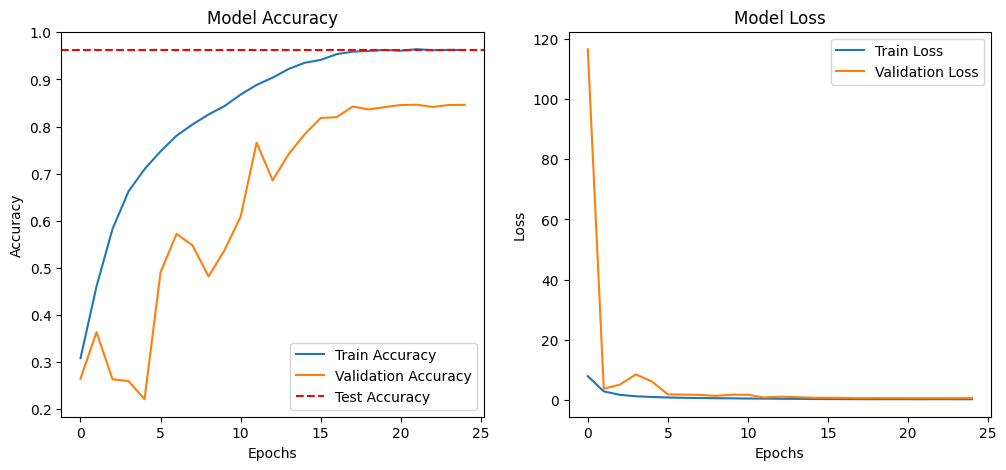

In [11]:
# Đánh giá mô hình
val_score = model.evaluate(val_generator, verbose=0)
test_score = model.evaluate(test_generator, verbose=0)
print(f'Validation Accuracy: {val_score[1] * 100:.2f}%')
print(f'Test Accuracy: {test_score[1] * 100:.2f}%')

# Vẽ biểu đồ kết quả
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_score[1], color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()